In [67]:
import glob
import numpy as np
import pandas as pd

# standard system modules
import os, sys

# to plot pixelized images
import imageio.v3 as im

import warnings

# Suppress all RuntimeWarnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

import scipy.ndimage as ndi
from skimage.feature import peak_local_max
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN, HDBSCAN

### Load the data

In [121]:
def load_data(path):
    runs = sorted(glob.glob(os.path.join(path, '*.txt')))
    datalist = [np.loadtxt(run, unpack = False) for run in runs]
    return datalist

SLABdat = load_data(path = './data/9kG/')
# i = 0
smoothed_data = ndi.gaussian_filter((SLABdat[0][:,0],SLABdat[0][:,1]), sigma=0.1)  # adjust sigma for smoothness

X = "ScintLeft"; Y = "AnodeBack"
SL_min = 0; SL_max = 4000
AB_min = 0 ; AB_max = 4000 

SLAB_full = pd.DataFrame(SLABdat[0], columns = [X,Y])
SLAB = SLAB_full[(SLAB_full[X] >= SL_min) & (SLAB_full[X] <= SL_max) & (SLAB_full[Y] >= AB_min) & (SLAB_full[Y] <= AB_max)]
SLAB = SLAB.reset_index(drop=True) # pandas keeps the indices of the original, we want to reset to avoid any future issues

# Rescales data to better interpret and get better cluster results
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(SLAB[[X, Y]]), columns = [X,Y])

# SLAB = SLAB_full[(SLAB_full[X] >= SL_min) & (SLAB_full[Y] >= AB_min)]

### Resample the data so that DBSCAN doesn't take forever

In [122]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def density_aware_resample(data, n_samples, n_subsets, k=10):
    """
    Resample the dataset in a density-aware manner.
    
    Parameters:
    - data: ndarray, the full dataset (shape: [n_samples, n_features])
    - n_samples: int, number of points per subset
    - n_subsets: int, number of subsets to create
    - k: int, number of nearest neighbors for density estimation

    Returns:
    - subsets: list of ndarray, resampled subsets
    """
    # Estimate local density using k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, _ = nbrs.kneighbors(data)
    local_density = 1 / (np.mean(distances, axis=1) + 1e-10)  # Avoid divide-by-zero
    
    # Invert densities to give higher weights to sparse regions
    weights = 1 / (local_density + 1e-10)
    weights /= np.sum(weights)  # Normalize weights
    
    # Generate subsets
    subsets = []
    for _ in range(n_subsets):
        sampled_indices = np.random.choice(len(data), size=n_samples, p=weights)
        subsets.append(data.iloc[sampled_indices])
    
    return subsets

def plot_subsets(subsets, figsize=(12, 8)):
    """
    Plot subsets in a grid of subplots.
    
    Parameters:
    - subsets: list of ndarray, the subsets to plot
    - figsize: tuple, size of the figure
    
    Returns:
    - None
    """
    n_subsets = len(subsets)
    cols = 3  # Number of columns in the subplot grid
    rows = (n_subsets + cols - 1) // cols  # Calculate rows needed

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten in case of extra empty axes

    for i, subset in enumerate(subsets):
        ax = axes[i]
        ax.scatter(subset['ScintLeft'], subset['AnodeBack'], s=10, marker = '.', alpha=0.7)
        # ax.set_title(f"Subset {i+1}")
        # ax.set_xlabel("Feature 1")
        # ax.set_ylabel("Feature 2")

    # Hide extra axes
    for j in range(len(subsets), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()




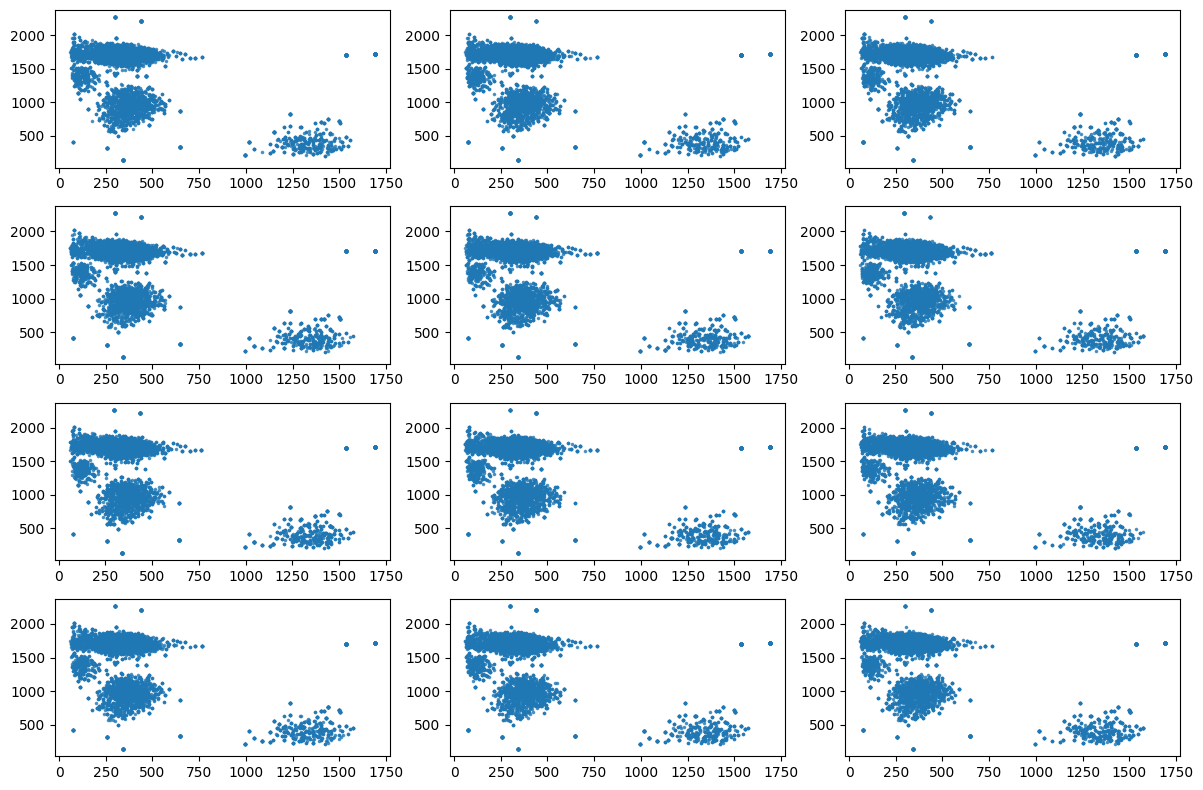

In [123]:
# X_sampled = pd.DataFrame(scaler.fit_transform(SLAB.iloc[0:10000]), columns = [X,Y])
# Assuming `data` is your dataset as a NumPy array
data = SLAB
n_subsets = 12
sample_k = 10
n_samples_per_subset = int(0.1 * len(data))  # % of the dataset
subsets = density_aware_resample(data, n_samples=n_samples_per_subset, n_subsets=n_subsets, k = sample_k)

# Example usage
plot_subsets(subsets)

### Try DBSCAN on a subset

6704
4
0.5094778891634156


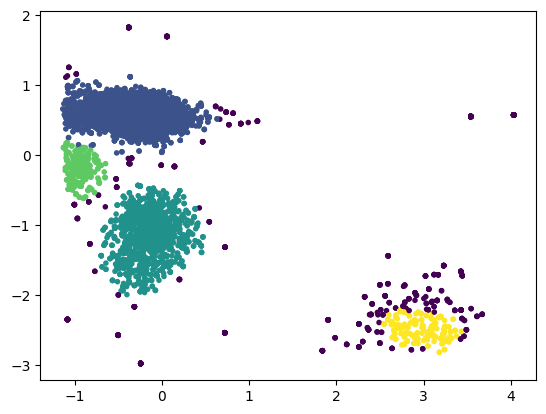

In [130]:
from sklearn.utils import resample

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(subsets[1]), columns = [X,Y])
X_sampled = scaled_data


# X_sampled = resample(scaled_data, replace = False, n_samples = 5000)
# X_sampled = scaled_data.iloc[0:10000]
db = DBSCAN(eps=0.2, min_samples=70).fit(X_sampled)
# db = HDBSCAN().fit(scaled_data)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(len(scaled_data))
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
# Plot result
SLAB = X_sampled
plt.figure()
plt.scatter(SLAB[X], SLAB[Y], marker = '.', c = db.labels_)
# plt.scatter(scaled_data[X], scaled_data[Y], marker = '.', c = db.labels_)

print(silhouette_score(X_sampled, db.labels_))

## Trying EMCEE approach to find optimal eps and min_samples inputs

In [42]:
# Define likelihood function
from sklearn.metrics import pairwise_distances
from sklearn.utils import resample
from sklearn.decomposition import PCA

def log_likelihood(params, X):
    # eps, min_samples = params
    if params[0] <= 0 or params[1] <1:
        return -np.inf
    X_sampled = resample(X, replace = False, n_samples = 1000)
    labels = DBSCAN(eps = params[0] , min_samples = int(params[1])).fit_predict(X_sampled)

    # penalize degenerate clustering 
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2 or n_clusters > 4: #too few or too many clusters
        return -np.inf

    # Compute Silhouette Score
    try:
        return 1 - silhouette_score(X_sampled, labels)
    except ValueError:
        return -np.inf

# Define prior
def log_prior(params):
    eps, min_samples = params
    if 0.01 < eps < 1.0 and 30 < min_samples < 90:
        return 0.0 # Uniform prior
    return -np.inf # outside bounds

# Define probability
def log_prob(params, X):
    if not np.isfinite(log_prior(params)):
        return -np.inf
    return log_prior(params) + log_likelihood(params, X)

In [107]:
# Initialize the emcee 
import emcee

initial = abs([0.2,70] - np.random.randn(32,2)*[0.2,10]) # initial guess
n_walkers, n_dim = initial.shape

# scaler = StandardScaler()
# subdata = pd.DataFrame(scaler.fit_transform(subsets[0]), columns = [X,Y])

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, args = [subsets[0]])
state = sampler.run_mcmc(initial, 100)
sampler.reset()
sampler.run_mcmc(state, 1000, progress = True)

# # Analyze results
flat_samples = sampler.get_chain(discard=10, thin=15, flat=True)
best_params = flat_samples[np.argmax(flat_samples[:, 0])]  # Choose based on likelihood

print(f"Best parameters: eps={best_params[0]}, min_samples={int(best_params[1])}")


100%|██████████| 1000/1000 [01:48<00:00,  9.23it/s]

Best parameters: eps=0.7864737183381136, min_samples=70


In [38]:
# np.set_printoptions(formatter={'float': '{:.2f}'.format})
# print(abs([0.3,50] - np.random.randn(20,2)*[0.1,30]))
print(len(subdata))

6704


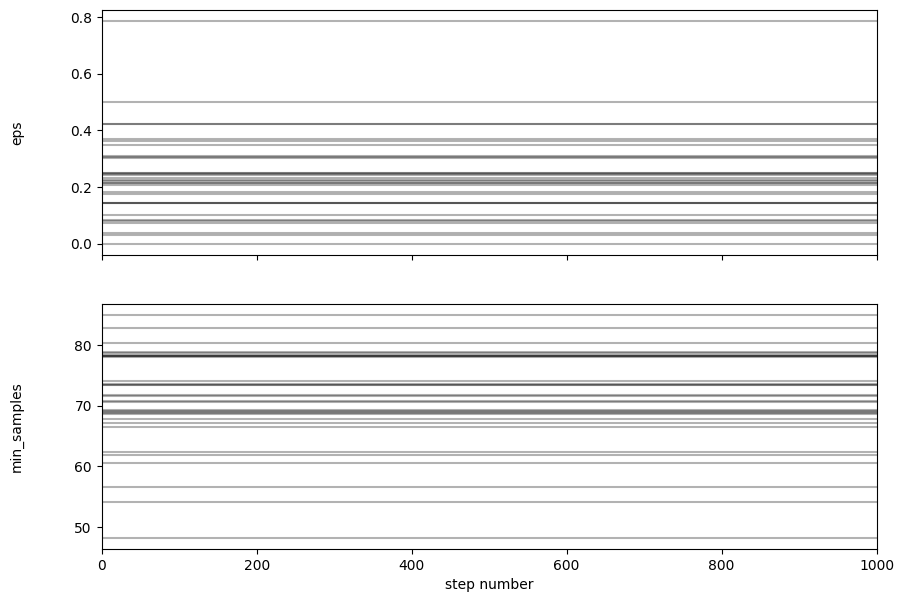

In [108]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['eps', 'min_samples']
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

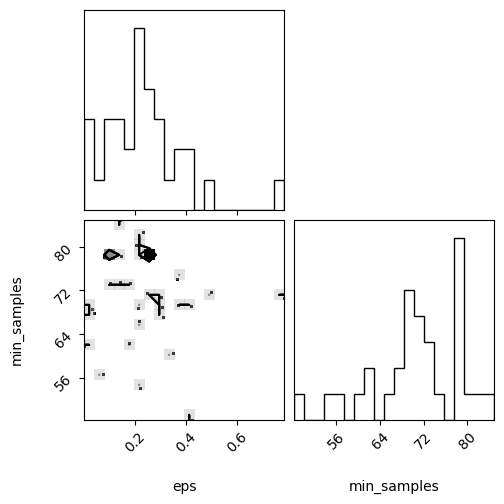

In [109]:
import corner
labels = ['eps', 'min_samples']
# f_true = 0.01
# a,b,c,d = param
fig = corner.corner(
    flat_samples, labels=labels
);

In [29]:
print(np.shape(abs([0.3,5] - np.random.randn(20,2)*[0.3,5])))

AttributeError: 'tuple' object has no attribute 'T'

In [ ]:
from multiprocessing import Pool
import emcee
import time
initial = [0.3,10] + 1e-4*np.random.rand(20,2) # initial guess
n_walkers, n_dim = initial.shape

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, args = [scaled_data.to_numpy()], pool=Pool())
start = time.time()
sampler.run_mcmc(initial, 100, progress=True)
end = time.time()
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))
# print("{0:.1f} times faster than serial".format(serial_time / multi_time))

In [4]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

32 CPUs


In [10]:
print([0.3,10] + 1e-1np.random.rand(20,2))

[[1.84341920e-01 6.52624908e+00]
 [8.14824635e-02 5.10865642e+00]
 [2.76980744e-01 3.07453416e-01]
 [2.07237494e-01 7.48177224e-01]
 [2.39744352e-02 8.66565875e-01]
 [2.69047933e-01 1.22379387e+00]
 [2.34297726e-01 9.40327699e+00]
 [7.09111144e-02 8.92269320e+00]
 [2.62726105e-01 1.43803841e+00]
 [2.80899672e-02 4.28252839e+00]
 [1.19703986e-01 8.83686688e+00]
 [2.02989628e-01 4.86690316e+00]
 [9.35181912e-03 8.20987826e+00]
 [1.35035715e-01 8.12108495e+00]
 [1.45144143e-01 3.99698512e+00]
 [1.32160943e-01 4.59002701e-01]
 [2.55170926e-01 9.78448062e+00]
 [1.33065414e-01 1.51311106e+00]
 [2.64158097e-01 1.38830942e+00]
 [1.34204034e-01 4.24554069e+00]]


In [ ]:
def normalize_eps(eps, subset_density, full_density):
    return eps * np.sqrt(full_density / subset_density)

def compute_density(data):
    return len(data) / np.prod(np.ptp(data, axis=0))  # Approximate density

# Calculate full dataset density
full_density = compute_density(data)

# Adjust `eps` for each subset
for params, subset in zip(best_params_list, subsets):
    subset_density = compute_density(subset)
    params['eps'] = normalize_eps(params['eps'], subset_density, full_density)
